# PHYS 210, Homework 17 (V2)
Due Wednesday, Nov 5, 2025 at the start of class on Canvas

# About this homework assignment

This homework assignment is designed to get everybody started on Project 03. It is considered Stage 1 of a 3-stage process in developing your project, as described in the [Project 03 Instructions](https://github.com/physics210/p210-2025/blob/main/docs/Project03-instructions.md). The starter code from these instructions is reproduced in an appendix at the end of this document

In this homework assignment, you are going to (1) trace the path of an initial neutron through multiple fission events, and then (2) reproduce the results for the simplified system introduced in the Project 03 Instructions.

# Task 1: Ensure that new neutrons are generated at the location where the parent was captured

Many students miss the following important detail from Step 6 of **3.2 Monte Carlo algorithm for the simplified system.**

> Keep in mind that each pair of new neutrons is generated at the locations where its parent was captured, not at random locations. Thus you need to the information about where the parent stopped if it stopped within the sample.

To ensure that you have implemented this step correctly:
1. Create a cube of side length $a = 10.0 \text{ cm}$, and then start a single Generation 0 neutron at a random location within the box, and travelling in a random direction. 
1. Implement the simplified system algorithm such that the neutron generates children if it is captured within the sample.
1. Allow the algorithm to continue through 2 generations.
1. Generate a plot that shows the trajectories of the Generation 0 neutron, the resulting Generation 1 neutrons, and the subsequent Generation 2 neutrons. This can be a 2D projection like Figure 1 below, or a 3D plot if you would like to try making one of those.

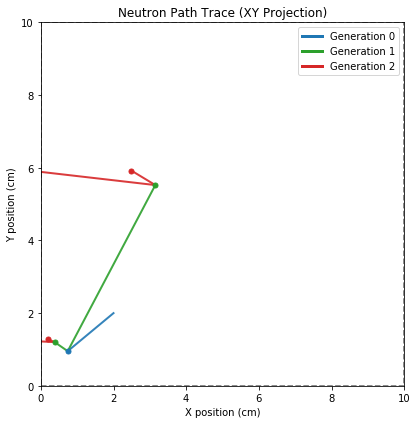

> **Fig. 1.** Example trace of neutron paths, showing the initial Generation 0 netron in blue, and the subsequent Generation 1 children in green starting from where the blue path ended. Then it shows the the four grandchildren in red, with each pair of grandchildren originating from where green Generation 1 neutron had a fission event. Note that for each of these Generation 2 pairs, one of the neutrons leaves the sample.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from dataclasses import dataclass
from collections import deque
from PIL import Image
import io

In [2]:
def save_graph_and_close():
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    graph = Image.open(buf)
    plt.close()
    return graph

In [3]:
MEAN_FREE_PATH = 2.65

def get_next_neutron_position(current_position):
    """
    Generates a random direction for the neutron 
    and uses the mean-free-path to calculate the
    next position for the neutron.
    """
    theta = np.random.uniform(0, 2 * np.pi)
    direction = np.array([ np.cos(theta), np.sin(theta) ])
    distance  = np.random.exponential(MEAN_FREE_PATH)
    
    return current_position + distance * direction

def test_get_next_neutron_position(num_samples=100_000, tol=0.05):
    """
    Note to future self: I just generated a few 
    tests with ChatGPT, but they all look good.
    """
    np.random.seed(0)
    current_position = np.array([0.0, 0.0])
    
    positions = np.array([get_next_neutron_position(current_position) for _ in range(num_samples)])
    displacements = positions - current_position
    distances = np.linalg.norm(displacements, axis=1)
    
    # --- 1. Output shape check ---
    assert positions.shape == (num_samples, 2), "Output should be 2D positions"
    
    # --- 2. Mean displacement ≈ mean free path ---
    mean_distance = distances.mean()
    assert abs(mean_distance - MEAN_FREE_PATH) / MEAN_FREE_PATH < tol, \
        f"Mean distance {mean_distance:.2f} differs too much from expected {MEAN_FREE_PATH:.2f}"
    
    # --- 3. Direction uniformity check (mean of cos(theta) and sin(theta) near 0) ---
    directions = displacements / distances[:, None]
    mean_dir = np.mean(directions, axis=0)
    assert np.allclose(mean_dir, [0, 0], atol=0.02), \
        f"Directions are not uniform (mean direction = {mean_dir})"
    
    # --- 4. Magnitude distribution sanity check (exponential shape) ---
    # Compare empirical mean to theoretical mean of exponential
    empirical_std = distances.std()
    theoretical_std = MEAN_FREE_PATH
    assert abs(empirical_std - theoretical_std) / theoretical_std < 0.1, \
        f"Standard deviation {empirical_std:.2f} should be near {theoretical_std:.2f}"
    
    print('Test Passed!')
    
test_get_next_neutron_position()

Test Passed!


In [4]:
@dataclass
class NeutronNode:
    start_pos: np.array          = None
    end_pos:   np.array          = None
    children:  list              = None
    lost:      bool              = False

In [5]:
def print_tree(node, indent=0):
    """Recursively pretty-print a neutron trajectory tree."""
    if node is None:
        print(" " * indent + "(empty node)")
        return
    
    space = "  " * indent
    start = tuple(np.round(node.start_pos, 2).tolist()) if node.start_pos is not None else None
    end   = tuple(np.round(node.end_pos, 2).tolist()) if node.end_pos is not None else None
    status = "lost" if node.lost else "active"
    
    print(f"{space}⤷ {status.upper()}  start={start}  →  end={end}")
    
    if node.children:
        for child in node.children:
            print_tree(child, indent + 1)

In [6]:
def traverse_tree(root):
    """
    A simple method for traversing the tree using BFS
    without having to re-implement it each time.
    """
    if root is None:
        return

    # (node, generation)
    queue = deque([(root, 0)])

    while queue:
        node, generation = queue.popleft()

        # yield data for the current node
        yield node.start_pos, node.end_pos, generation

        # enqueue children if they exist
        if node.children:
            for child in node.children:
                queue.append((child, generation + 1))

def test_traverse_tree(debug_print=False):
    root = NeutronNode(
        start_pos = np.array([0, 0]), 
        end_pos   = np.array([1, 1]),
        
        children  = [
            NeutronNode(
                start_pos = np.array([1, 1]), 
                end_pos   = np.array([2, 1]),
                
                children  = [
                    NeutronNode(
                        start_pos = np.array([2, 1]),
                        end_pos   = np.array([4, 3])
                    ),
                    
                    NeutronNode(
                        start_pos = np.array([2, 1]),
                        end_pos   = np.array([3, 2])
                    )
                ]
            ),
            
            NeutronNode(
                start_pos = np.array([1, 1]), 
                end_pos   = np.array([1, 2])
            )
        ]
    )

    if debug_print:
        for start_pos, end_pos, generation in traverse_tree(root):
            print(generation, start_pos, end_pos)
    
    assert len(list(traverse_tree(root))) == 5
    print("Test Passed!")
    
test_traverse_tree()

Test Passed!


In [7]:
def random_position_in_box(side_length):
    return np.random.uniform(0, side_length, 2)

def is_outside_box(pos, size):
    return pos[0] < 0 or pos[0] >= size or pos[1] < 0 or pos[1] >= size

def generate_children(start_pos, n, size):
    children = []
    for _ in range(n):
        end_pos = get_next_neutron_position(start_pos)
        
        children.append(NeutronNode(
            start_pos = start_pos,
            end_pos   = end_pos,
            lost      = is_outside_box(end_pos, size)
        ))
    return children

In [8]:
def generate_tree_recursive(parent, gen, max_generations, size):
    """
    Generates the neutron tree using in place tail recursion 
    """
    
    if gen >= max_generations or parent.lost:
        parent.children = []
        return
    
    parent.children = generate_children(parent.end_pos, 2, size)
    for child in parent.children:
        generate_tree_recursive(child, gen + 1, max_generations, size)

In [9]:
def generate_tree(num_generations, side_length):
    """
    Calculates the trajectories (start and end points) for each 
    Neutron Generation by building a Neutron tree with BFS alongside
    the replication numbers for each generation transition.
    """
    initial_pos = random_position_in_box(side_length)
    end_pos     = get_next_neutron_position(initial_pos)
    
    root = NeutronNode(
        start_pos = initial_pos,
        end_pos   = end_pos,
        lost      = is_outside_box(end_pos, side_length)
    )
    
    generate_tree_recursive(root, 0, num_generations, side_length)
    
    return root

def test_generate_tree():
    print_tree(generate_tree(3, 10))
    print('Test Passed!')
    
test_generate_tree()

⤷ LOST  start=(2.18, 5.87)  →  end=(10.14, 5.25)
Test Passed!


### Plotting

In [10]:
@dataclass
class SimulationResult:
    trajectories_graph: Image
    result_trees:       NeutronNode

In [11]:
def plot_trajectories(trees, num_generations, size):
    fig, ax = plt.subplots(figsize=(6, 6))
    cmap = plt.get_cmap("viridis")
    
    # For legend handles (store one Line2D per generation)
    generation_handles = {}
    colors = ['blue', 'red', 'green', 'orange', 'magenta']
    
    for tree in trees:
        for start_pos, end_pos, generation in traverse_tree(tree):
            if start_pos is None or end_pos is None:
                continue
                
            color = colors[generation]
            
            # Draw the trajectory line
            (line,) = ax.plot(
                [start_pos[0], end_pos[0]],
                [start_pos[1], end_pos[1]],
                color=color,
                alpha=0.8,
                linewidth=1.2,
                label=f"Gen {generation}"
            )

            # Mark start (circle) and end (X)
            ax.scatter(*end_pos, color=color, marker='o', s=12.5, alpha=0.7)

            # Save one handle per generation for legend
            if generation not in generation_handles:
                generation_handles[generation] = line

    # Add legend (one entry per generation)
    ax.legend(
        handles=[generation_handles[g] for g in sorted(generation_handles)],
        labels=[f"Generation {g}" for g in sorted(generation_handles)],
        title="Generations",
        loc="upper right"
    )

    ax.set_title("Neutron Branching Paths by Generation")
    ax.set_xlabel("x position")
    ax.set_ylabel("y position")
    ax.set_xlim(0, size)
    ax.set_ylim(0, size)

    return save_graph_and_close()

In [12]:
def simulate(num_generations, size, num_initial_neutrons=1, plot=False):
    result_trees = [generate_tree(num_generations, size) \
                    for i in range(num_initial_neutrons)]
    
    graph=None
    if plot:
        graph = plot_trajectories(result_trees, num_generations, size)
    
    return SimulationResult(
        trajectories_graph = graph,
        result_trees       = result_trees
    )

#### Test

In [13]:
test = simulate(3, 10, plot=True)

In [14]:
for result_tree in test.result_trees:
    print_tree(result_tree)

⤷ ACTIVE  start=(3.43, 3.94)  →  end=(2.57, 3.43)
  ⤷ ACTIVE  start=(2.57, 3.43)  →  end=(3.78, 1.83)
    ⤷ ACTIVE  start=(3.78, 1.83)  →  end=(4.34, 0.55)
      ⤷ LOST  start=(4.34, 0.55)  →  end=(3.93, -0.62)
      ⤷ LOST  start=(4.34, 0.55)  →  end=(7.24, -1.98)
    ⤷ ACTIVE  start=(3.78, 1.83)  →  end=(1.36, 4.19)
      ⤷ LOST  start=(1.36, 4.19)  →  end=(-7.09, 7.76)
      ⤷ ACTIVE  start=(1.36, 4.19)  →  end=(1.78, 3.99)
  ⤷ ACTIVE  start=(2.57, 3.43)  →  end=(2.51, 2.7)
    ⤷ ACTIVE  start=(2.51, 2.7)  →  end=(2.14, 0.31)
      ⤷ ACTIVE  start=(2.14, 0.31)  →  end=(0.1, 2.89)
      ⤷ ACTIVE  start=(2.14, 0.31)  →  end=(1.66, 0.85)
    ⤷ ACTIVE  start=(2.51, 2.7)  →  end=(2.62, 2.84)
      ⤷ ACTIVE  start=(2.62, 2.84)  →  end=(1.62, 4.58)
      ⤷ ACTIVE  start=(2.62, 2.84)  →  end=(1.91, 2.53)


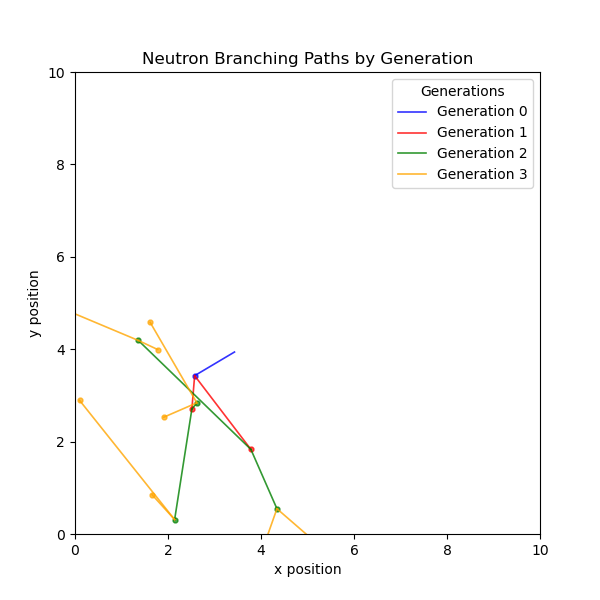

In [15]:
display(test.trajectories_graph)

# Task 2: Replicate the example results for for the simplified system with of a cube of side length $a = 10.0 \text{ cm}$, $N_0 = 250$ initial neutrons and $m_\text{replications}$ = 300




**Step 1:** Build on the starter code from Project 03 Instructions to enact in full the described simple model algorithm of the system. It is best to build functions to help with many of the repeated tasks. Determine the average, standard deviation and standard uncertainty of the mean of the multiplication factor $k$ for each generation going to the next. Check that your (mean ± standard uncertainty of the mean) values of $k_{01}$, $k_{12}$ and $k_{23}$ are consistent with those from the figure below. You do not need to generate histograms, but may find them helpful as a troubleshooting tool if you are struggling to get values that are consistent with the figure below.

**Step 2 (optional):** Spend some time exploring the trade-offs of increasing or decreasing $N_0$ in exchange for similar decreases or increases of $m_\text{replications} = 300$. Which of these impacts the stanard uncerainty of the mean for $k$? What other impacts do you notice from changing these values? This exploration can help inform your how small or large you want to make the quantities in your full version of the simulation.

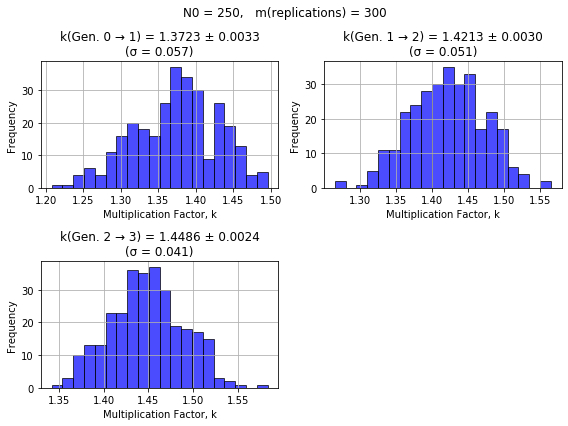

> **Fig. 2.** Example multiplication factor results for a Uranium 235 cube of side length $a = 10.0 \text{ cm}$, with $N_0 = 250$ initial neutrons. Each of the three panels shows the multiplication factor going from one generation to the next, with each replication representing one data point. The title of each plot shows the mean ± standard uncertainty in the mean (standard deviation divided by $\sqrt{m}$) of the multiplication factor for that generation, across all replications. It also shows the standard deviation (σ).

In [16]:
def get_neutrons_in_each_generation(tree):
    """
    Counts the number of neutrons in each generation
    """
    counts = []

    for _, _, generation in traverse_tree(tree):
        if len(counts) <= generation:
            counts.append(0)
        counts[generation] += 1

    return np.array(counts)

In [17]:
def calculate_k_values(tree, max_generations):
    """
    From a neutron tree, return an array of k values (n_next / n_current)
    for each generation. 
    """
    counts = get_neutrons_in_each_generation(tree)
    return counts[1:] / counts[:-1]

In [34]:
# Step 1: Your code here to show your mean k values for each generation, 
# with standard uncertainties of the mean

def simulate_all(a, N0, m_reps, max_generation=3):
    results_pool = [[] for _ in range(max_generation)]
    
    for i in range(m_reps):
        simulation_result = simulate(max_generation, a, num_initial_neutrons=N0, plot=False).result_trees
        for tree in simulation_result:
            k_values = calculate_k_values(tree, max_generation)
            for i, k in enumerate(k_values):
                results_pool[i].append(k)
    
    print([len(lst) for lst in results_pool])
    generation_data = results_pool
    
    means = np.array([np.mean(g) for g in generation_data])
    std_devs = np.array([np.std(g) for g in generation_data])
    stderrs = np.array([np.std(g)/np.sqrt(len(g)) for g in generation_data])

    # plot data
    
    for gen in range(len(generation_data)):
        k_values = generation_data[gen]
        k_mean   = means[gen]
        k_stddev = std_devs[gen]
        k_stderr = k_stddev / np.sqrt(m_reps)
        
        plt.figure(figsize=(6, 4))

        # Histogram
        plt.hist(
            k_values,
            bins=10,
            alpha=0.6,
            edgecolor="black",
            color=plt.get_cmap("viridis")(gen / max(1, max_generation-1))
        )

        # Vertical line for mean
        plt.axvline(k_mean, color='red', linestyle="--", linewidth=1.5)

        # Titles and labels
        plt.title(f"Generation {gen}")
        plt.xlabel("k value")
        plt.ylabel("Frequency")
        plt.grid(alpha=0.3)

        # Text box with stats
        plt.text(
            0.95, 0.95,
            f"$\\bar{{k}}$={k_mean:.3f}\n±{k_stderr:.3f} (stderr)\nσ={k_stddev:.3f}",
            verticalalignment='top',
            horizontalalignment='right',
            transform=plt.gca().transAxes,
            fontsize=10,
            bbox=dict(facecolor='white', alpha=0.6, edgecolor='gray')
        )

        plt.tight_layout()
        plt.show()

[53202, 48551, 46508]


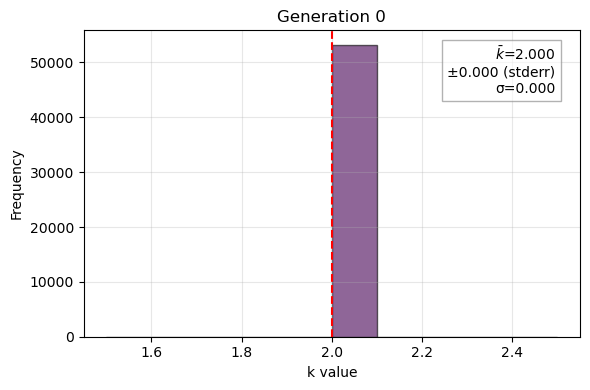

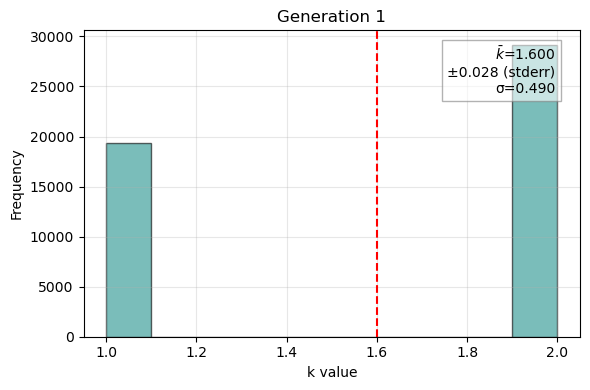

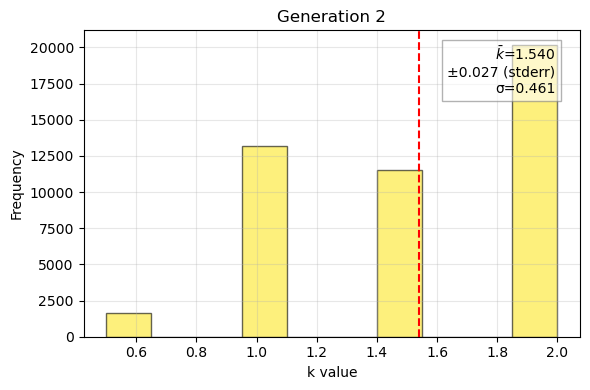

In [35]:
simulate_all(a=10, N0=250, m_reps=300)

**Step 2 (optional) observations:**

* Observation 1
* Observation 2
* ..



## *Appendix 1. Starter code*

The starter code below is the result of some initial brainstorming with Fermi. It shows how to generate a neutron at a random position within the cube of Uranium, and then generate a random direction (in 3D) and travel distance for the neutron. 

Some additional functionality you should consider:

* Move it from generating a single neutron, to $N_0$ neutrons. Recall that all of the `np.random` functions take array shape as their final positional argument. For example, you can generate $N_0$ initial positions using `x0 = np.random.uniform(0, a, N0)`. Or if you wanted a multi-dimensional position array you could use `r0 = np.random.uniform( 0, a, (3, N0) )`.
* It is likely you will want to move some of this functionality to functions, especially as you generate multiple neutrons and propagte them across multiple generations.

Additional notes:

* The method used of generating a random direction in 3d may seem a bit counterintuitive. Try searching or asking GenAI about this using a phrase such as "pick a random point on the surface of a sphere with a uniform distribution."
* It is best to use very low numbers for `N0` and `replications` as you build and test your code so that you are not waiting around forever while developing your code. Once you want to check results, increase these value up to or close to the final values you wish to use.

```python
# Length of the cube's side
a = 10.0 # cm

# Fermi's best guess of the mean free path
# based on the neutron cross section in U235
# across many energies
mean_free_path = 2.65 # cm

# Generate a random initial decay position for each neutron
# - These positions will only be random for the Generation 0 neutrons
x0 = np.random.uniform(0, a)
y0 = np.random.uniform(0, a)
z0 = np.random.uniform(0, a)

# Generate random initial directions for each neutron
phi = np.random.uniform(0, 2 * np.pi)
costheta = np.random.uniform(-1, 1)
theta = np.arccos(costheta)

# Randomly generate the distance travelled for a neutron 
# before it is absorbed. This comes from the proabability 
# p(L) ∝ e^{-L/λ} that a neutron will be captured after
# travelling a distance L
d = np.random.exponential(mean_free_path)

# ... (determine final positions, etc)
```

# Completing Homework 17 and submitting it to Canvas
Before submitting your work, restart + rerun your entire notebook to make sure that everything runs correctly and without error.

To do this:
1. **Restart & Run All:** From the "Kernel" menu to the right of the "Cell" menu, select "Restart & Run All". This will restart the python Kernel, erasing all variables currently stored in memory so that when you "Run All" cells, you can ensure that if you were to run your notebook again on a later day, it would run as intended.
1. Look through the whole notebook and make sure there are no errors. Many questions have purposeful errors in the distributed version so make sure you have fixed them all such that "Restart & Run All" will run through the whole book and successfully print "The notebook ran without errors" at the end. If you have any trouble resolving the errors, please ask one of your classmates or ask us in class or on Piazza.

**Export notebook as HTML:** After you've executed and checked your notebook, choose: File => Save_and_Export_Notebook_As => HTML. This will download an HTML version of your notebook to your computer. This version is can not be executed or modified. You may need to disable any pop-up blockers to allow the file to be downloaded.

**Submit to Canvas:** Submit the html file that you just downloaded AND your .ipynb file to the Homework 05 submission quiz on Canvas.